## BCH pediatrics trends: query and plot
This notebook includes the SQL code used to extract the information regarding pediatric patients with a mental ICD-10 code condition (the full list can be found here: https://github.com/hms-dbmi/psy_peds_trends/blob/main/data/pediatric%20psychiatric%20ICD-10%20codes_adjusted.csv).

The inclusion criteria is:
- inpatients
- Sars-Cov-2 PCR  positive or negative (no filter by covid-19 condition, just PCR test done at BCH)
- filtered by age (11-17)
- 21st April 2020 - Up to date 
- The ICD-10 code from the list as Primary diagnosis (modifier → ICD:P) 

In [ ]:
#CREATE TABLE ag440_mental_health
#AS SELECT obs.patient_num, obs.concept_cd, obs.start_date, pat.birth_date, floor(months_between(obs.start_date, pat.birth_date) / 12) as age, 
#         peds_codes.mental_health_disorder_group,  peds_codes.description, obs.modifier_cd, vis.inout_cd
#FROM observation_fact obs
#INNER JOIN patient_dimension pat ON obs.patient_num=pat.patient_num
#INNER JOIN visit_dimension vis ON obs.encounter_num= vis.encounter_num
#INNER JOIN ASE_PEDS_ICD_CODES peds_codes ON obs.concept_cd=peds_codes.ICD10_CODE
#WHERE floor(months_between(obs.start_date, pat.birth_date) / 12) > 10 
#      AND floor(months_between(obs.start_date, pat.birth_date) / 12) < 18 
#      AND lower(vis.inout_cd) = 'inpatient';

The output is a table that contains:
- patient identifier
- concept code (ICD-10 code)
- start date (day-month-year, 30-SEP-20)
- birth date (day-month-year, 30-SEP-03)
- age (in years)
- the mentah health disorder group (as described in the reference table)
- the description of each diagnosis
- modifier (ICD:P as primary diagnosis, ICD:S as secondary diagnosis if secondary diagnosis included)
- inout_cd (that includes the information for that patient and time as inpatient in this case)

### Barplot representation
Using as input the previous table we generate a barplot representing the number of cases per week starting the 21st April 2021 up to date. 

In [1]:
#load the libraries
library(dplyr)
library(ggplot2)
library(RColorBrewer)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
options(repr.plot.width = 18, repr.plot.height = 9)

In [31]:
theme_plots <- theme_bw() +
  theme(axis.text.y = element_text(size=18), 
        axis.text.x = element_text(size=18,angle = 45, vjust = 1, hjust=1),
        axis.title = element_text(size=20), 
        strip.text = element_text(size=20),
        strip.text.y = element_text(angle = 0),
        legend.text = element_text(size=16), 
        legend.title = element_text(size=16), 
        title = element_text(size=20), 
        plot.subtitle = element_text(face = "italic")) 

### Data Management

In [5]:
#read the file with the dataset
output <- read.delim("mentalHealthPrimary.tsv")

# filter by date, to include only those starting the 21st April 2021
output$date <- sapply(strsplit( output$START_DATE, " "), '[', 1)
output$date <- as.Date( output$date, "%d/%m/%y")

# breaks by week
output$weeks <- cut(output[,"date"], breaks="week")
output$year <-sapply(strsplit( as.character(output$weeks), "-"), '[', 1) 
output <- output[output$date > "2020-04-21",]
output$period <- ifelse(output$date < "2020-04-21", 
                        "pre", ifelse(
                            output$date < "2021-01-01", 
                            "early_pandemic", 
                            "late_pandemic")
                        )
output <- output[output$period %in% c("early_pandemic", "late_pandemic"), ]


# all variables to lowercase
names(output) <- tolower(names(output))
names(output)[names(output) == "mental_health_disorder_group"] <- "category"
output$age_cat <- as.factor(ifelse(output$age >= 11, "11-17", "6-10"))

## Patients count per week

In [6]:
#select the patient identifier and the week and remove potential duplicates 
subset <- unique(output[ , c("patient_num", "weeks")])
print(paste("Number of unique patients seen per week: ", length(unique(subset$patient_num))))
summary(subset$week)

[1] "Number of unique patients seen per week:  3795"


2021-03-01 2021-02-08 2021-01-25 2020-11-16 2021-01-04 2021-03-08 2021-03-15 
       425        397        392        388        386        386        385 
2021-01-11 2021-03-22 2020-12-14 2021-04-05 2021-02-22 2020-10-12 2020-10-26 
       378        373        371        366        360        359        357 
2021-02-01 2020-11-30 2021-01-18 2020-12-07 2020-11-02 2020-11-09 2021-03-29 
       353        352        350        349        345        331        331 
2020-10-19 2020-08-24 2020-09-14 2020-10-05 2020-09-21 2020-09-07 2020-07-13 
       330        321        313        306        297        292        287 
2020-08-03 2021-02-15 2020-09-28 2020-08-10 2020-08-31 2020-07-20 2020-07-27 
       286        282        281        280        280        271        269 
2020-08-17 2020-07-06 2020-06-01 2020-05-18 2020-12-21 2020-11-23 2020-06-08 
       269        261        260        257        253        251        246 
2020-05-11 2020-06-15 2020-04-27 2020-06-22 2020-05-04 2020-05-25 2020-12-28 
       245        244        239        239        234        233        215 
2020-06-29 2021-04-12 2020-04-20 2014-02-17 2014-02-24 2014-03-03 2014-03-10 
       214        210        162          0          0          0          0 
2014-03-17 2014-03-24 2014-03-31 2014-04-07 2014-04-14 2014-04-21 2014-04-28 
         0          0          0          0          0          0          0 
2014-05-05 2014-05-12 2014-05-19 2014-05-26 2014-06-02 2014-06-09 2014-06-16 
         0          0          0          0          0          0          0 
2014-06-23 2014-06-30 2014-07-07 2014-07-14 2014-07-21 2014-07-28 2014-08-04 
         0          0          0          0          0          0          0 
2014-08-11 2014-08-18 2014-08-25 2014-09-01 2014-09-08 2014-09-15 2014-09-22 
         0          0          0          0          0          0          0 
2014-09-29 2014-10-06 2014-10-13 2014-10-20 2014-10-27 2014-11-03 2014-11-10 
         0          0          0          0          0          0          0 
2014-11-17 2014-11-24 2014-12-01 2014-12-08 2014-12-15 2014-12-22 2014-12-29 
         0          0          0          0          0          0          0 
2015-01-05    (Other) 
         0          0

# Weekly patient counts with mental health related ICD codes plots

### Overall in and outpatients

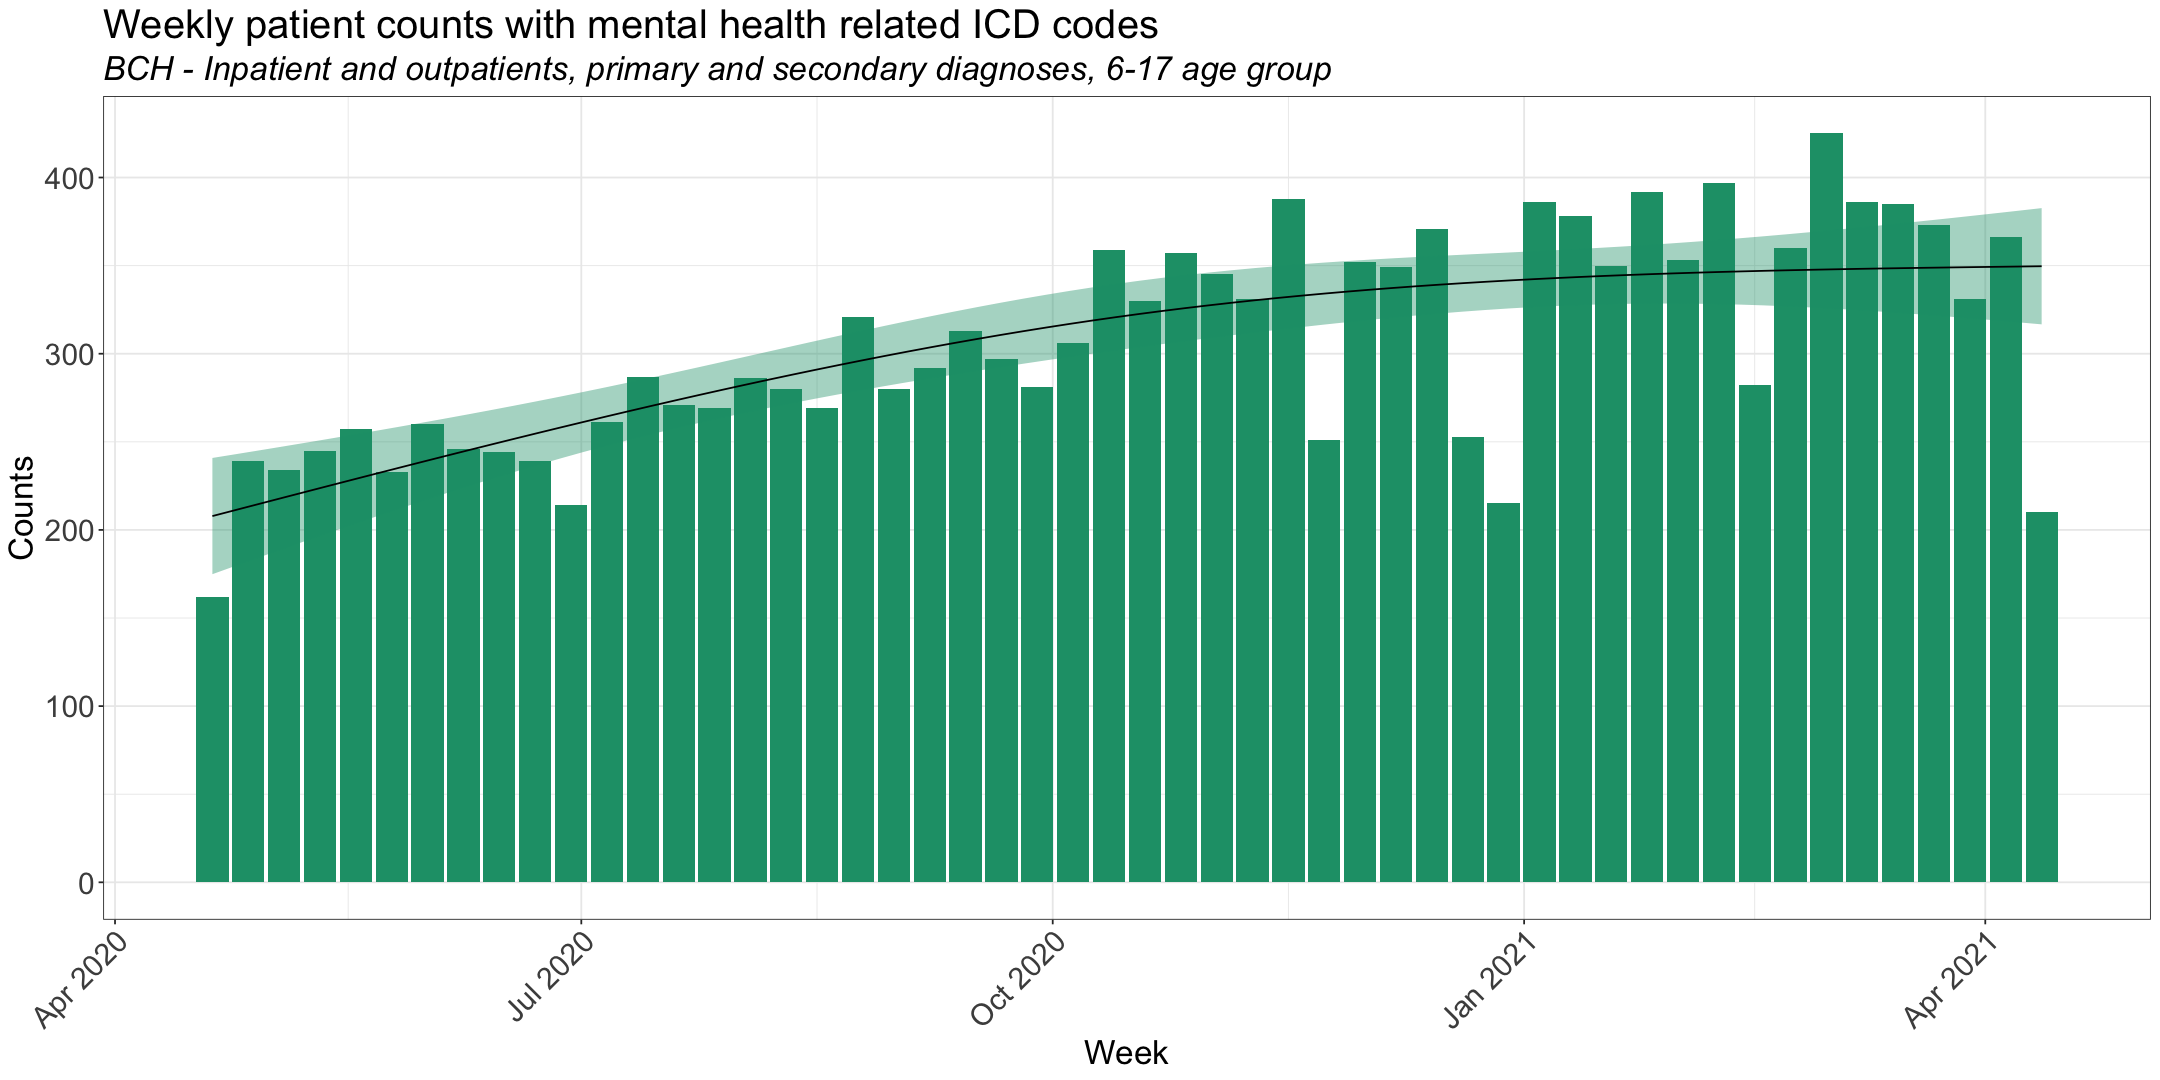

In [34]:
#estimate the number of patients per week
output[, c("patient_num", "weeks")] %>%
  unique() %>%
  group_by(weeks) %>%
  tally() %>%
  ggplot(aes(x = as.Date(weeks), y = n, fill = "Patients count")) +
  geom_bar(stat="identity")+
  labs(y = "Counts",
       x = "Week",
       title = "Weekly patient counts with mental health related ICD codes",
       subtitle = "BCH - Inpatient and outpatients, primary and secondary diagnoses, 6-17 age group") + 
  theme_plots + 
  theme(legend.position = "none") + 
  scale_fill_brewer(palette = "Dark2") +
  geom_smooth(method = "lm", formula = y ~ splines::ns(x, 2), se = TRUE, aes(colour=period), colour= "black", size = 0.5)
ggsave("../export/overall_weekly_count.png", width = 18, height = 9, units="in")

### Subsetting inpatients, 6-17 age group, primary and secondary diagnosis

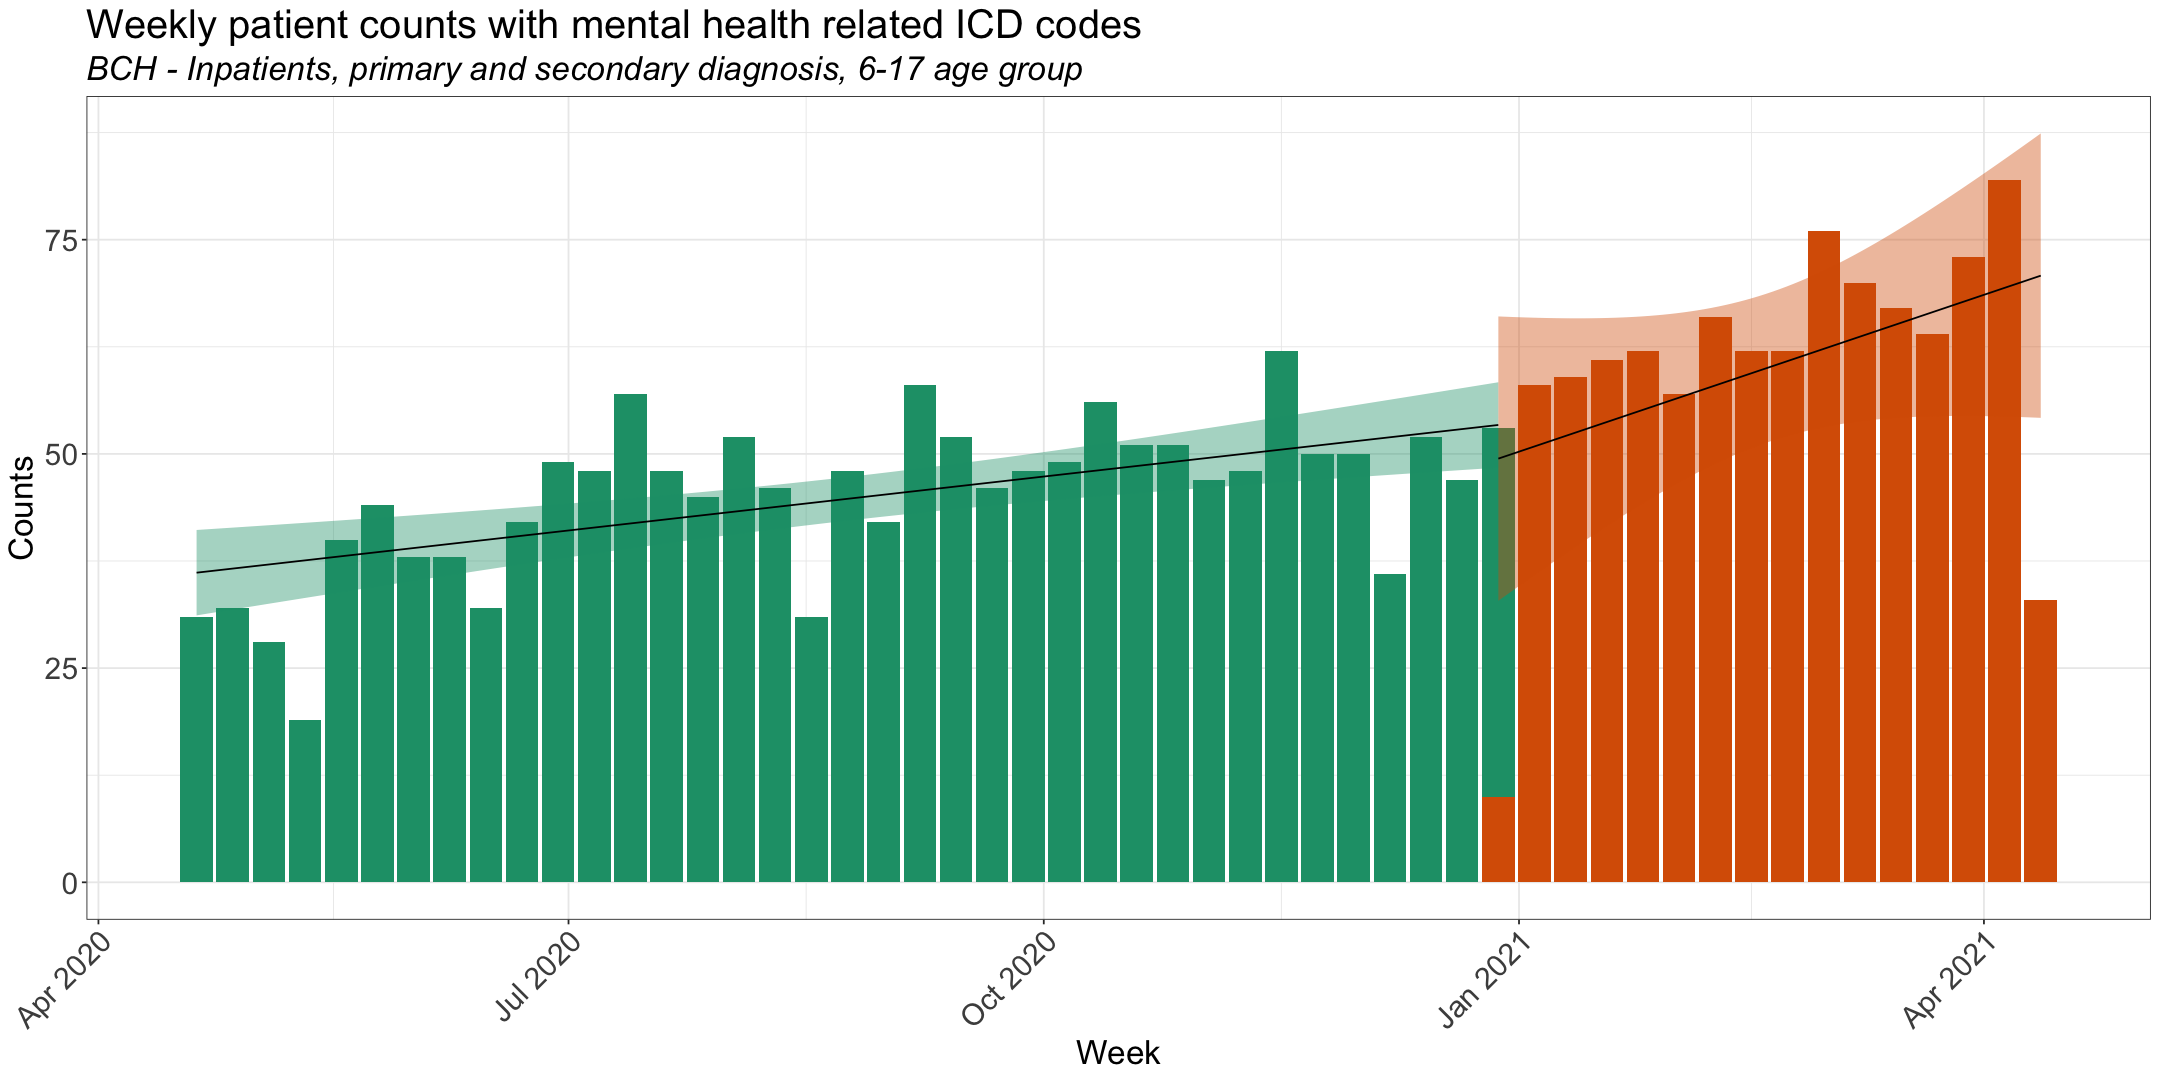

In [29]:
output[output$age_cat %in% c("6-10", "11-17") & output$inout_cd == "Inpatient", c("patient_num", "weeks", "period")] %>%
  unique() %>%
  group_by(weeks, period) %>%
  tally() %>%
  ggplot(aes(x = as.Date(weeks), y = n, fill = period)) +
  geom_bar(stat="identity")+
  labs(y = "Counts",
       x = "Week",
       title = "Weekly patient counts with mental health related ICD codes",
       subtitle = "BCH - Inpatients, primary and secondary diagnosis, 6-17 age group") + 
  theme_plots +
  theme(legend.position = "none") + 
  scale_fill_brewer(palette = "Dark2")+
  geom_smooth(method = "lm", formula = y ~ x, se = TRUE, aes(colour=period), colour= "black", size = 0.5)

ggsave("../export/inpatients_primary_secondary_6-17_count.png", width = 18, height = 9, units="in")

### Subsetting inpatients and 11-17 age group, primary and secondary diagnosis

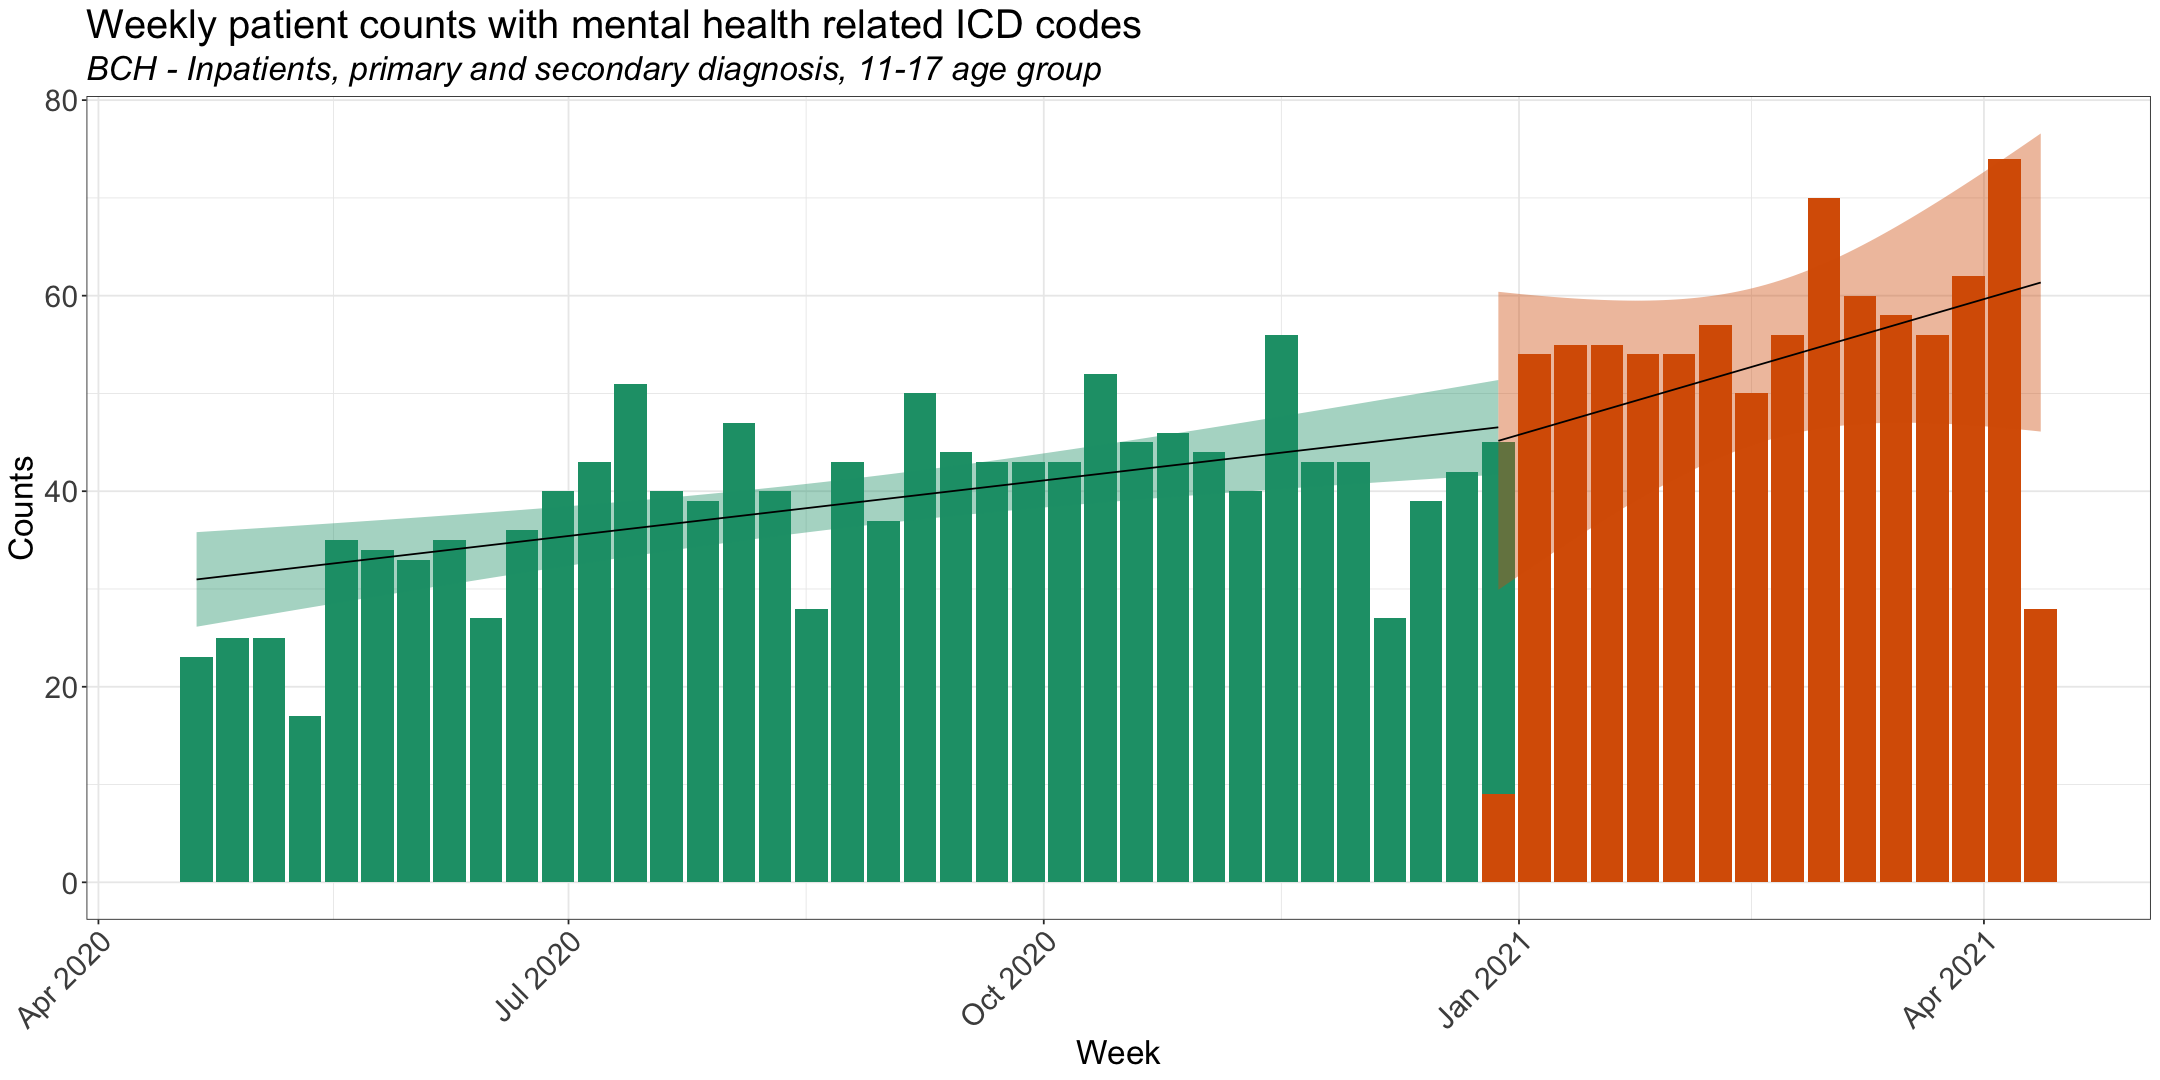

In [30]:
output[output$age_cat == "11-17" & output$inout_cd == "Inpatient", c("patient_num", "weeks", "period")] %>%
  unique() %>%
  group_by(weeks, period) %>%
  tally() %>%
  ggplot(aes(x = as.Date(weeks), y = n, fill = period)) +
  geom_bar(stat="identity")+
  labs(y = "Counts",
       x = "Week",
       title = "Weekly patient counts with mental health related ICD codes",
       subtitle = "BCH - Inpatients, primary and secondary diagnosis, 11-17 age group") + 
  theme_plots +
  theme(legend.position = "none") + 
  scale_fill_brewer(palette = "Dark2")+
  geom_smooth(method = "lm", formula = y ~ x, se = TRUE, aes(colour=period), colour= "black", size = 0.5)

ggsave("../export/inpatients_primary_secondary_teens_count.png", width = 18, height = 9, units="in")

#### By ICD subgroup category

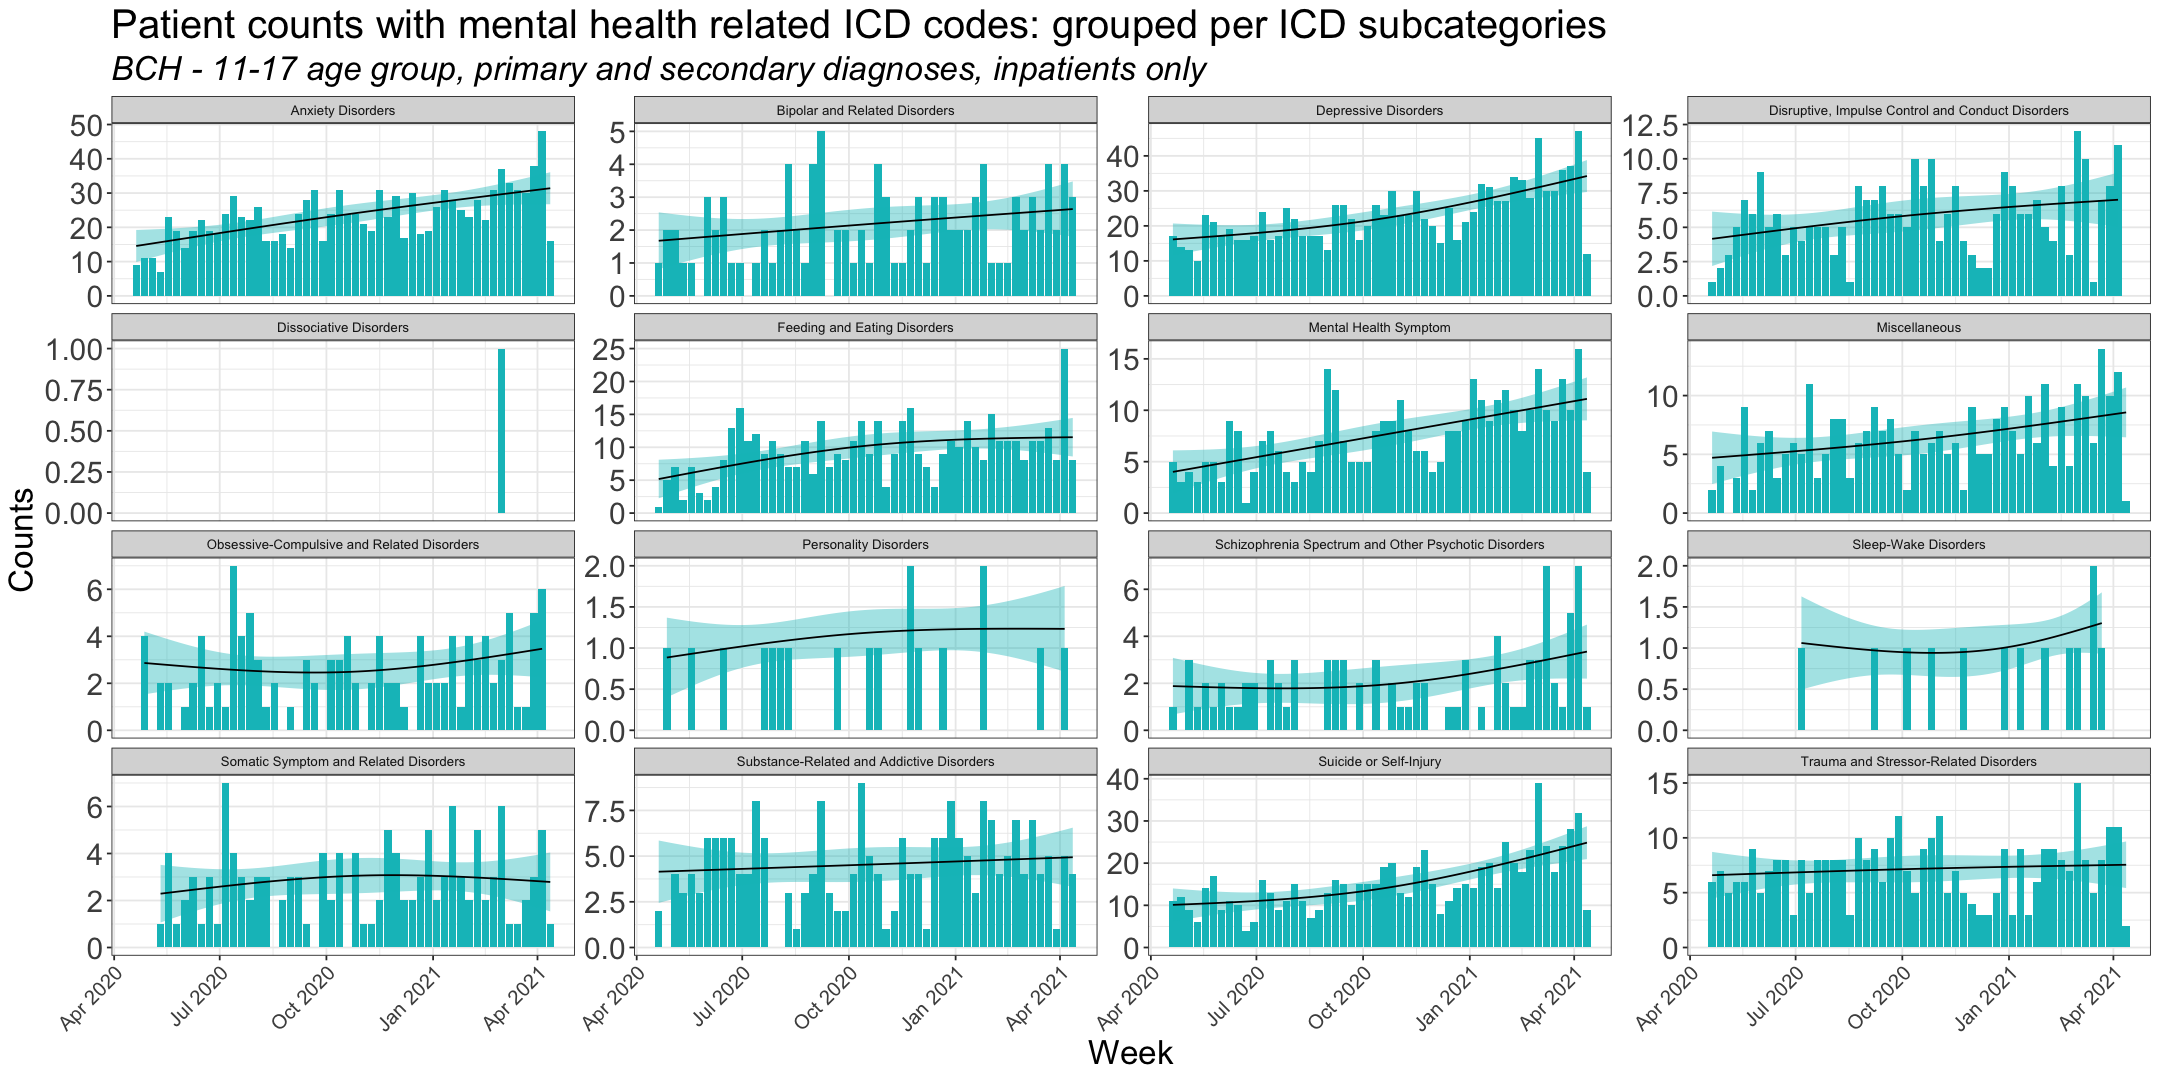

In [33]:
output[output$inout_cd == "Inpatient" & output$age_cat == "11-17" ,c("patient_num", "weeks", "category")] %>%
  unique() %>%
  group_by(weeks, category) %>% tally() %>%
  ggplot(aes(x = as.Date(weeks), y= n, fill = "", group = category )) +
  geom_bar(stat = "identity")+
  labs(x = "Week",
       y = "Counts",
       title = "Patient counts with mental health related ICD codes: grouped per ICD subcategories", 
       subtitle = "BCH - 11-17 age group, primary and secondary diagnoses, inpatients only") + 
  scale_fill_manual(values=c('#00BFC4'))+
  geom_smooth(method = "lm", formula = y ~ splines::ns(x, 2), se= TRUE, aes(colour=period), colour= "black", size = 0.5) + 
  ylim(0, NA) + 
  facet_wrap(. ~ category, scales = "free_y") +
  theme_plots + 
  theme(strip.text.x = element_text(size = 8),
        axis.text.x = element_text(size = 12), 
        legend.position = "none")
ggsave("../export/categorical_counts_inpatient_teens.png", width = 18, height = 9, units="in")

### Subsetting to primary diagnosis, inpatients and 11-17 age group

In [ ]:
#estimate the number of patients per week
output[output$age_cat == "11-17" & output$modifier_cd == "ICD:P" & output$inout_cd == "Inpatient", c("patient_num", "weeks")] %>%
  unique() %>%
  group_by(weeks) %>%
  tally() %>%
  ggplot(aes(x = as.Date(weeks), y = n, fill = "Patients count")) +
  geom_bar(stat="identity")+
  labs(y = "Counts",
       x = "Week",
       title = "Weekly patient counts with mental health related ICD codes",
       subtitle = "BCH - Inpatients, primary diagnosis, 11-17 age group") + 
  theme_plots +
  theme(legend.position = "none") + 
  scale_fill_brewer(palette = "Dark2") +
  geom_smooth(method = "lm", formula = y ~ splines::ns(x, 2), se = TRUE, aes(colour=period), colour= "black", size = 0.5)
ggsave("../export/inpatients_primary_teens_count.png", width = 18, height = 9, units="in")

#### By ICD subgroup category

In [ ]:
output[output$inout_cd == "Inpatient" & output$modifier_cd == "ICD:P" & output$age_cat == "11-17" ,c("patient_num", "weeks", "category")] %>%
 unique() %>%
 group_by(weeks, category) %>% tally() %>%
ggplot(aes(x = as.Date(weeks), y= n, fill = "", group = category )) +
  geom_bar(stat = "identity")+
  labs(x = "Week",
       y = "Counts",
       title = "Patient counts with mental health related ICD codes: grouped per ICD subcategories", 
       subtitle = "BCH - 11-17 age group, primary diagnoses, inpatients only") + 
  scale_fill_brewer(palette = "Dark2") +
  geom_smooth(method = "lm", formula = y ~ splines::ns(x, 2), se= TRUE, aes(colour=period), colour= "black", size = 0.5) + 
  ylim(0, NA) + 
  facet_wrap(. ~ category, scales = "free_y") +
  theme_plots + 
  theme(strip.text.x = element_text(size = 8),
        axis.text.x = element_text(size = 12), 
       legend.position = "none")
ggsave("../export/categorical_counts_inpatient_teens.png", width = 18, height = 9, units="in")

### By ICD subgroup categories

In [ ]:
#### by group category
output[ ,c("patient_num", "weeks", "category")] %>%
 unique() %>%
 group_by(weeks, category) %>% tally() %>%
ggplot(aes(x = as.Date(weeks), y= n, fill = "", group = category )) +
  geom_bar(stat = "identity")+
  labs(x = "Week",
       y = "Counts",
       title = "Patient counts with mental health related ICD codes: grouped per ICD subcategories", 
       subtitle = "BCH - 6-17 age group, primary and secondary diagnoses, inpatients only") + 
  scale_fill_brewer(palette = "Dark2") +
  geom_smooth(method = "lm", formula = y ~ splines::ns(x, 2), se= TRUE, aes(colour=period), colour= "black", size = 0.5)+ 
  facet_wrap(. ~ category, scales = "free_y")+
  theme_plots + 
  theme(strip.text.x = element_text(size = 8),
        axis.text.x = element_text(size = 12), 
       legend.position = "none")
ggsave("../export/categorical_counts.png", width = 18, height = 9, units="in")

### Inpatient/outpatients and age group trends comparisons

In [ ]:
#represent it as a barplot
unique(output[ , c("patient_num", "weeks", "age_cat", "inout_cd")]) %>%
group_by(weeks, age_cat, inout_cd) %>%
tally() %>%
ggplot(aes(x= as.Date(weeks), y=n, fill=age_cat)) +
  geom_bar(position="dodge", stat="identity")+
  ylab("Counts") + 
  xlab("Week") +
  facet_grid("age_cat ~ inout_cd", scales="free_y") +
  theme_plots +
  scale_fill_brewer(palette="Paired") +
  labs(title = "Patient counts with mental health related ICD codes: age comparison",
       subtitle = "(BCH) - Primary and secondary diagnoses") +
  geom_smooth(method = "lm", formula = y ~ splines::ns(x, 2), colour="black", se= TRUE, size = 0.5)
ggsave("../export/age_inoutpatients_comparison.png", width = 18, height = 9, units="in")

### Inpatient weekly count, 11-17 age group

In [ ]:
output[output$inout_cd == "Inpatient" , c("patient_num", "weeks", "age_cat")] %>%
unique() %>%
group_by(weeks, age_cat) %>%
tally() %>%
ggplot(aes(x= as.Date(weeks), y=n, fill=age_cat)) +
  geom_bar(position="dodge", stat="identity") +
  labs(title = "Weekly patient counts with mental health related ICD codes: age comparison", 
       subtitle = "BCH - Primary and secondary diagnoses, inpatients only", 
       fill = "Age", 
       x = "Counts", 
       y = "Week") +
  facet_grid("age_cat ~ . ", scales = "free_y") +
  theme_plots +
  scale_fill_brewer(palette = "Paired") +
  geom_smooth(method = "lm", formula = y ~ splines::ns(x, 2), colour="black", se= TRUE, size = 0.5)
ggsave("../export/age_inpatients_comparison.png", width = 18, height = 9, units="in")

### Inpatient weekly count, 6-10 age group

In [ ]:
#represent it as a barplot
output[output$inout_cd == "Outpatient" , c("patient_num", "weeks", "age_cat")] %>%
unique() %>%
group_by(weeks, age_cat) %>%
tally() %>%
ggplot(aes(x= as.Date(weeks), y=n, fill=age_cat)) +
  geom_bar(position="dodge", stat="identity")+
  labs(y = "Counts",  
       x = "Week",
       title = "Weekly patient counts with mental health related ICD codes: age comparison", 
       subtitle = "BCH - Primary and secondary diagnoses, outpatients only", 
       fill = "Age") +
  facet_grid("age_cat ~ . ", scales="free_y") +
  theme_plots +
  scale_fill_brewer(palette="Paired") +
  geom_smooth(method = "lm", formula = y ~ splines::ns(x, 2), colour="black", se= TRUE, size = 0.5)
ggsave("../export/age_outpatients_comparison.png", width = 18, height = 9, units="in")

### ICD subcategories weekly count, inpatient in 11-17 age group

In [ ]:
#represent it as a barplot
output %>% 
filter(age_cat == "11-17",
       inout_cd == "Inpatient") %>%
select(patient_num, weeks, category) %>%
unique() %>%
group_by(weeks, category) %>%
tally() %>%
ggplot(aes(x= as.Date(weeks), y=n, fill="age")) +
  geom_bar(position="dodge", stat="identity")+
  facet_wrap("category", scales="free_y") +
  labs(title = "Weekly patient counts with mental health related ICD codes: grouped per ICD subcategories", 
       subtitle = "BCH - 11-17 age group, primary and secondary diagnoses, inpatients only", 
       y = "Counts", 
       x = "Week") +
  theme_plots + 
  theme(legend.position = "none", 
       strip.text.x = element_text(size = 8)) +
  geom_smooth(method = "lm", formula = y ~ splines::ns(x, 2), colour="black", se= TRUE, size = 0.5) +
  scale_fill_manual(values = brewer.pal(3, "Paired")[2])
ggsave("../export/inpatient_subcategories_teens.png", width = 18, height = 9, units="in")

In [ ]:
#represent it as a barplot
output %>% 
filter(age_cat == "11-17") %>%
select(patient_num, weeks, category) %>%
unique() %>%
group_by(weeks, category) %>%
tally() %>%
ggplot(aes(x= as.Date(weeks), y=n, fill="age")) +
  geom_bar(position="dodge", stat="identity")+
  facet_wrap("category", scales="free_y") +
  labs(title = "Weekly patient counts with mental health related ICD codes: grouped per ICD subcategories", 
       subtitle = "BCH - 11-17 age group, primary and secondary diagnoses, inpatients and outpatients", 
       y = "Counts", 
       x = "Week") +
  theme_plots + 
  theme(legend.position = "none", 
       strip.text.x = element_text(size = 8)) +
  geom_smooth(method = "lm", formula = y ~ splines::ns(x, 2), colour="black", se= TRUE, size = 0.5) +
  scale_fill_manual(values = brewer.pal(3, "Paired")[2])
ggsave("../export/subcategories_teens.png", width = 18, height = 9, units="in")

### ICD subcategories weekly count, inpatient in 6-10 age group

In [ ]:
output %>% 
filter(age_cat == "6-10",
       inout_cd == "Inpatient") %>%
select(patient_num, weeks, category) %>%
unique() %>%
group_by(weeks, category) %>%
tally() %>%
ggplot(aes(x= as.Date(weeks), y=n, fill="age")) +
  geom_bar(position="dodge", stat="identity")+
  facet_wrap("category", scales="free_y") +
  labs(ttitle = "Weekly patient counts with mental health related ICD codes: grouped per ICD subcategories", 
       subtitle = "BCH - 6-10 age group, primary and secondary diagnoses, inpatients only", 
       y = "Counts", 
       x = "Week") +
  theme_plots + 
  theme(legend.position = "none", 
       strip.text.x = element_text(size = 8)) +
  geom_smooth(method = "lm", formula = y ~ splines::ns(x, 2), colour="black", se= TRUE, size = 0.5) +
  scale_fill_manual(values = brewer.pal(3, "Paired")[1])
ggsave("../export/inpatient_subcategories_kids.png", width = 18, height = 9, units="in")

In [ ]:
output %>% 
filter(age_cat == "6-10") %>%
select(patient_num, weeks, category) %>%
unique() %>%
group_by(weeks, category) %>%
tally() %>%
ggplot(aes(x= as.Date(weeks), y=n, fill="age")) +
  geom_bar(position="dodge", stat="identity")+
  facet_wrap("category", scales="free_y") +
  labs(ttitle = "Weekly patient counts with mental health related ICD codes: grouped per ICD subcategories", 
       subtitle = "BCH - 6-10 age group, primary and secondary diagnoses, inpatients and outpatients", 
       y = "Counts", 
       x = "Week") +
  theme_plots + 
  theme(legend.position = "none", 
       strip.text.x = element_text(size = 8)) +
  geom_smooth(method = "lm", formula = y ~ splines::ns(x, 2), colour="black", se= TRUE, size = 0.5) +
  scale_fill_manual(values = brewer.pal(3, "Paired")[1])
ggsave("../export/subcategories_kids.png", width = 18, height = 9, units="in")

### Primary vs secondary diagnosis comparison

#### Inpatients 11-17 years old

In [ ]:
output %>% 
  filter(age_cat == "11-17",
         inout_cd == "Inpatient") %>% 
  select(patient_num, weeks, modifier_cd) %>%
  mutate(modifier_cd = recode(modifier_cd, "ICD:P" = "Primary Diagnosis", "ICD:S" = "Secondary Diagnosis")) %>%
  unique() %>%
  group_by(weeks, modifier_cd) %>%
  tally() %>%
  ggplot(aes(x= as.Date(weeks), y=n, fill=modifier_cd)) +
  geom_bar(position="dodge", stat="identity")+
  ylab("counts") + 
  xlab("Week") +
  facet_grid(". ~ modifier_cd ", scales="free_y") +
  labs(title = "Patient counts with mental health ICD codes: primary and secondary outcomes comparison", 
       subtitle = "BCH - 11-17 age group, inpatients", 
       y = "Counts", 
       x = "Week") +
  theme_plots + 
  theme(legend.position = "none") +
  scale_fill_brewer(palette="Set2") +
  geom_smooth(method = "lm", formula = y ~ splines::ns(x, 2), colour="black", se= TRUE, size = 0.5)
ggsave("./primary_secondary_diagnoses_comparison.png", width = 18, height = 9, units="in")

#### Inpatients and outpatients 6-17 years old

In [ ]:
output %>% 
select(patient_num, weeks, modifier_cd) %>%
mutate(modifier_cd = recode(modifier_cd, "ICD:P" = "Primary Diagnosis", "ICD:S" = "Secondary Diagnosis")) %>%
unique() %>%
group_by(weeks, modifier_cd) %>%
tally() %>%
ggplot(aes(x= as.Date(weeks), y=n, fill=modifier_cd)) +
  geom_bar(position="dodge", stat="identity")+
  ylab("counts") + 
  xlab("Week") +
  facet_grid(". ~ modifier_cd ", scales="free_y") +
  labs(title = "Patient counts with mental health ICD codes: primary and secondary outcomes comparison", 
       subtitle = "BCH - 6-17 age group, in and outpatients", 
       y = "Counts", 
       x = "Week") +
  theme_plots + 
  theme(legend.position = "none") +
  scale_fill_brewer(palette="Set2") +
  geom_smooth(method = "lm", formula = y ~ splines::ns(x, 2), colour="black", se= TRUE, size = 0.5)
ggsave("../export/primary_secondary_diagnoses_comparison.png", width = 18, height = 9, units="in")